# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

2. А также ответить на ключевые вопросы HR-агентства:
    - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    - Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    - Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Ответить на поставленные вопросы нам помогут предоставленные данные:

- work_year - Год, в котором была выплачена зарплата.

- experience_level - Опыт работы на этой должности в течение года со следующими возможными значениями:
    - EN — Entry-level/Junior;
    - MI — Mid-level/Intermediate;
    - SE — Senior-level/Expert;
    - EX — Executive-level/Director.
    
- employment_type - Тип трудоустройства для этой роли:
    - PT — неполный рабочий день;
    - FT — полный рабочий день;
    - CT — контракт;
    - FL — фриланс.
- job_title - Роль, в которой соискатель работал в течение года.

- salary - Общая выплаченная валовая сумма заработной платы.

- salary_currency - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.

- salary_in_usd - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).

- employee_residence - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.

- remote_ratio - Общий объём работы, выполняемой удалённо. Возможные значения:
    - 0 — удалённой работы нет (менее 20 %);
    - 50 — частично удалённая работа;
    - 100 — полностью удалённая работа (более 80 %).

- company_location - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.

- company_size - Среднее количество людей, работавших в компании в течение года:
    - S — менее 50 сотрудников (небольшая компания);
    - M — от 50 до 250 сотрудников (средняя компания);
    - L — более 250 сотрудников (крупная компания).

In [118]:
# импортируем необходимые библиотеки

import pandas as pd
from sklearn import datasets
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.contingency_tables import mcnemar

# делаем визуальную настройку графиков

sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [119]:
# Загружаем данные и выведем начало датасета

data = pd.read_csv('data/ds_salaries.csv')
display(data.head(3))



,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M


In [120]:
#задаем уровень значимости alpha

alpha = 0.05
print(f'Уровень значимости alpha = {alpha}')

Уровень значимости alpha = 0.05


 ## EDA - Описательный анализ данных ##

In [121]:
# Выводим основную иноформацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей, пропущенных значений нет. 

Из предоставленных данных можно выделить следующие признаки как категориальные и количественные:

Категориальные признаки:

- __work_year__
- __experience_level__
- __employment_type__
- __job_title__
- __salary_currency__
- __employee_residence__
- __company_location__
- __company_size__
- __remote_ratio__

Количественные признаки:

- __salary__
- __salary_in_usd__


Ниже перечисленные признаки можно будет удалить, так как они не будут участвовать в исследовании:

- __Unnamed: 0__: Этот признак кажется лишним, поскольку он, вероятно, представляет собой индекс или идентификатор записи. 

- __salary_currency__ и __salary__: Если есть столбец __salary_in_usd__ для приведения всех зарплат к одной валюте (USD), то столбцы __salary_currency__ и __salary могут__ быть удалены, так как они уже несут дублирующую информацию.
- __employee_residence__ и __company_location__ : данная информация не будет использоваться в исследовании

In [122]:
# Уберем ненужные признаки
data = data.drop(['Unnamed: 0', 'salary', 'salary_currency', 'company_location', 'employee_residence'], axis=1)



In [123]:
# Преобразуем признак work_year и remote_ratio в object
data['work_year'] = data['work_year'].astype('object')
data['remote_ratio'] = data['remote_ratio'].astype('object')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   work_year         607 non-null    object
 1   experience_level  607 non-null    object
 2   employment_type   607 non-null    object
 3   job_title         607 non-null    object
 4   salary_in_usd     607 non-null    int64 
 5   remote_ratio      607 non-null    object
 6   company_size      607 non-null    object
dtypes: int64(1), object(6)
memory usage: 33.3+ KB


In [124]:
# Проверяем датасет на наличие дубликатов
duplicates = data[data.duplicated()].shape[0]
print(f'Количество дубликатов составляет: {duplicates}')

# Удаляем дубликаты

data = data.drop_duplicates()
print(f'Размер датасета после удаления дубликатов: {data.shape}')

Количество дубликатов составляет: 48
Размер датасета после удаления дубликатов: (559, 7)


In [125]:
# Добавим два новый признак 'job_group', чтобы иметь возможность работать сразу с группой должностей, относящихся к Data Scientist и Data Engineer
# если в названии должностей есть слова Data Engineer, то их будем относить к Data Engineer, а если Data Scien - то к Data Scientist

data['job_group'] = data['job_title'].apply(lambda x: 'Data Engineer' if 'Data Engineer' in x else 'Data Scientist' if 'Data Scien' in x else 'other')


In [126]:
# Заменим значения в признаках experience_level, employment_type и company_size для лучшего отображения на графиках


data['experience_level'] = data['experience_level'].replace('EN', 'Entry-level/Junior')
data['experience_level'] = data['experience_level'].replace('EX', 'Executive-level/Director')
data['experience_level'] = data['experience_level'].replace('MI', 'Mid-level/Intermediate')
data['experience_level'] = data['experience_level'].replace('SE', 'Senior-level/Expert')

data['employment_type'] = data['employment_type'].replace('FT', 'полный рабочий день')
data['employment_type'] = data['employment_type'].replace('CT', 'контракт')
data['employment_type'] = data['employment_type'].replace('FL', 'фриланс')
data['employment_type'] = data['employment_type'].replace('PT', 'неполный рабочий день')

data['company_size'] = data['company_size'].replace('L', "Large")
data['company_size'] = data['company_size'].replace('M', "Medium")
data['company_size'] = data['company_size'].replace('S', "Small")

### Распределение зарплат среди всех должностей

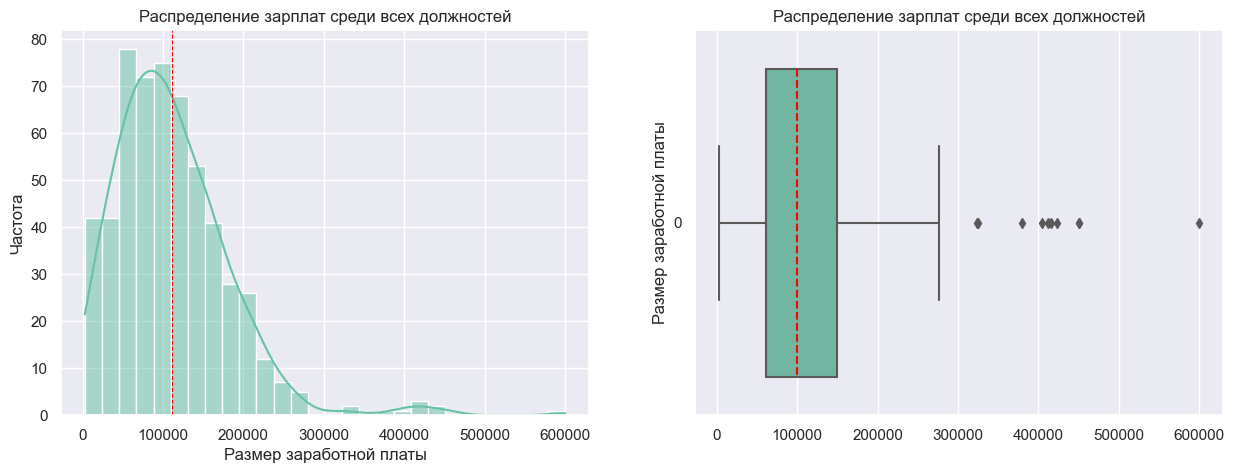

In [127]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы', ylabel='Частота')
axes[0].set_title('Распределение зарплат среди всех должностей')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер заработной платы')
axes[1].set_title('Распределение зарплат среди всех должностей')

plt.show()

In [128]:
salary_statisctics = data['salary_in_usd'].describe().round(2).to_frame()
salary_statisctics.columns = ['Размер зарплат в Data Science']
display(salary_statisctics)

,Размер зарплат в Data Science
count,559.00
mean,111158.54
std,72445.74
min,2859.00
25%,61383.50
50%,100000.00
75%,150000.00
max,600000.00


Распределение зарплат отлично от нормального, имеются выбросы.

### Распределение зарплат для должностей, относящихся к Data Science и Data Engineer, в 2022 году

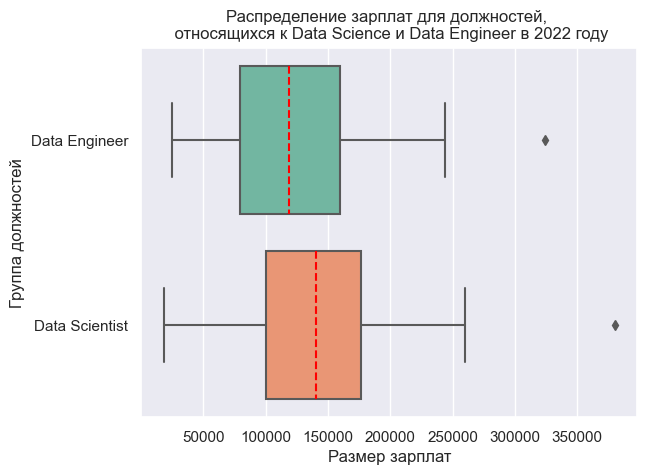

In [129]:
filtered_data = data[(data['work_year'] == 2022) & (data['job_group'] != 'other')]

ax = sns.boxplot(filtered_data, x='salary_in_usd', y='job_group', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Группа должностей')
plt.title('Распределение зарплат для должностей, \n относящихся к Data Science и Data Engineer в 2022 году')
plt.show()

In [130]:
salary_statisctics = filtered_data.groupby('job_group')['salary_in_usd'].describe().round(2)
print('')
display(salary_statisctics)

,count,mean,std,min,25%,50%,75%,max
job_group,,,,,,,,
Data Engineer,76.0,127439.42,57472.87,25000.0,79631.5,119093.5,160080.0,324000.0
Data Scientist,78.0,139940.54,61627.85,18442.0,100000.0,140400.0,176750.0,380000.0


При первом приближении кажется, что уровень зарплат для должностей Data Science слегка выше, чем длю должностей Data Engineer. Статистические тестирования покажут, действительно ли это так.

### Распределение зарплат в зависимости от опыта работы

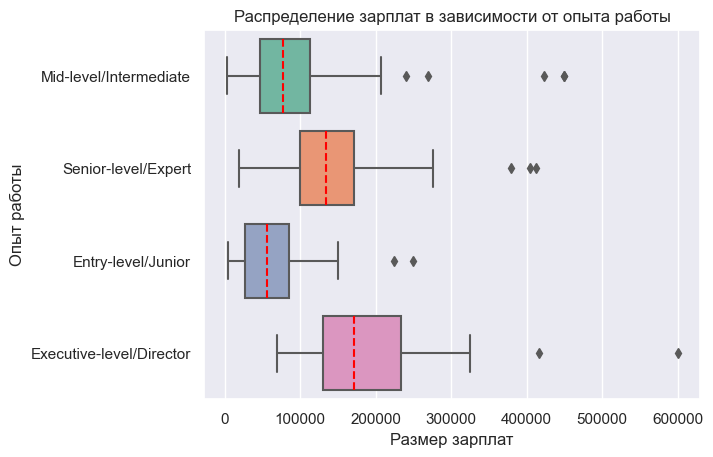

In [131]:
ax = sns.boxplot(data, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Опыт работы')
plt.title('Распределение зарплат в зависимости от опыта работы')
plt.show()

In [132]:
salary_statisctics = data.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('')
display(salary_statisctics)

,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
Entry-level/Junior,88.0,61643.32,44395.54,4000.0,27505.0,56500.0,85425.75,250000.0
Executive-level/Director,26.0,199392.04,117071.26,69741.0,130006.5,171437.5,233750.00,600000.0
Mid-level/Intermediate,202.0,88632.28,64795.69,2859.0,47461.5,77161.0,112729.00,450000.0
Senior-level/Expert,243.0,138374.88,59955.97,18907.0,99531.5,135000.0,171881.00,412000.0


Судя по графику, опыт работы напрямую влияет на размер зарплаты. С увеличение опыта растет и зарплата. 

### Распределение зарплат в зависимости от типа трудоустройства

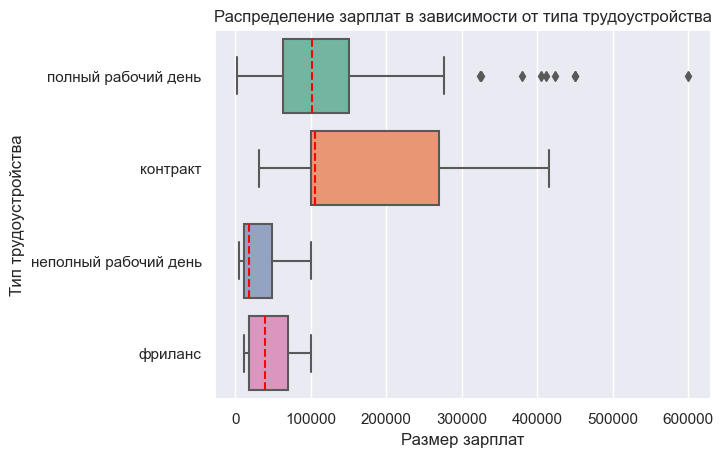

In [133]:
ax = sns.boxplot(data, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Тип трудоустройства')
plt.title('Распределение зарплат в зависимости от типа трудоустройства')
plt.show()

In [134]:
salary_statisctics = data.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('')
display(salary_statisctics)

,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
контракт,5.0,184575.00,156250.89,31875.0,100000.00,105000.0,270000.0,416000.0
неполный рабочий день,10.0,33070.50,31472.91,5409.0,12000.00,18817.5,48370.0,100000.0
полный рабочий день,540.0,112392.67,70938.49,2859.0,63464.75,101835.0,150000.0,600000.0
фриланс,4.0,48000.00,40529.82,12000.0,18000.00,40000.0,70000.0,100000.0


Для работающих на котрактной основе уровень зарплат выше, чем для остальных типов трудоустройства, однако, учитывая  малое количество сотрудников с данным типом трудоустройства (5 человек) и большой разброс зарплат, нельзя достоверно утверждать, что работа по контракту вцелом позволяет получать более высокую зарплату. Аналогичный вывод можно сделать и для работающих на фрилансе (имеются данные всего о четырех сотрудниках) - здесь нельзя с полной уверенностью утверждать, что фриланс приносить меньше денег, чем работа по контракту или на полный рабочий день. Сравнивая же работающих полный рабочий день и работников с частичной занятостью, первые получают значительно более высокую зарплату.

### Распределение зарплат в зависимости от размера компании

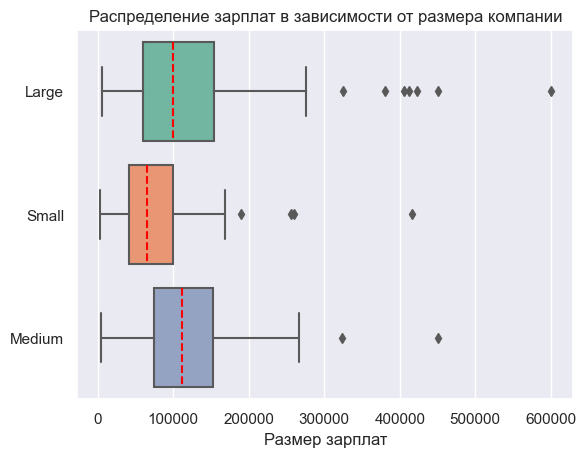

In [135]:
ax = sns.boxplot(data, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='')
plt.title('Распределение зарплат в зависимости от размера компании')
plt.show()

In [136]:
salary_statisctics = data.groupby('company_size')['salary_in_usd'].describe().round(2)
print('')
display(salary_statisctics)

,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
Large,193.0,118213.88,86753.27,5882.0,60000.0,100000.0,153667.0,600000.0
Medium,284.0,115974.76,60815.33,4000.0,74245.5,111350.0,152625.0,450000.0
Small,82.0,77872.10,63814.52,2859.0,41816.0,65511.0,100000.0,416000.0


Судя по графику, зарплаты специалистов Data Science в небольших компаниях ниже, чем в средних и крупных. Тогда как в крупных и средних размеры зарплат весьма близки. Достоверно подтвердить данное утвержение можно будет с помощью статистических тестов далее в исследовании.


### Распределение зарплат по годам

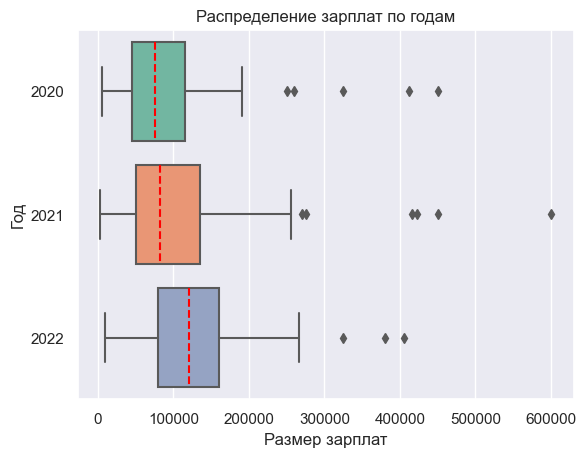

In [137]:
ax = sns.boxplot(data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Год')
plt.title('Распределение зарплат по годам')
plt.show()

In [138]:
salary_statisctics = data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('')
display(salary_statisctics)

,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021,215.0,99430.41,80304.32,2859.0,50000.0,82528.0,135000.0,600000.0
2022,272.0,124490.98,59720.87,10000.0,80000.0,120000.0,160000.0,405000.0


Судя по графику, наблюдается рост зарплат специалистов Data Science от года к году. Достоверно подтвердить данное утвержение можно будет с помощью статистических тестов далее в исследовании.

### Распределение зарплат в зависимости от объема удаленной работы

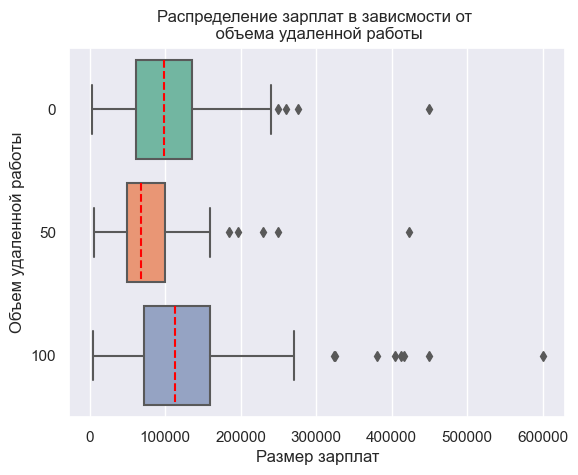

In [139]:
ax = sns.boxplot(data, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Объем удаленной работы')
plt.title('Распределение зарплат в зависмости от \n объема удаленной работы')
plt.show()

In [140]:
salary_statisctics = data.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('')
display(salary_statisctics)

,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,121.0,105785.40,68392.50,2859.0,62000.0,98158.0,136000.00,450000.0
50,98.0,80721.90,57639.10,5409.0,50000.5,68010.5,99925.75,423000.0
100,340.0,121843.65,75099.49,4000.0,71700.5,112600.0,160000.00,600000.0


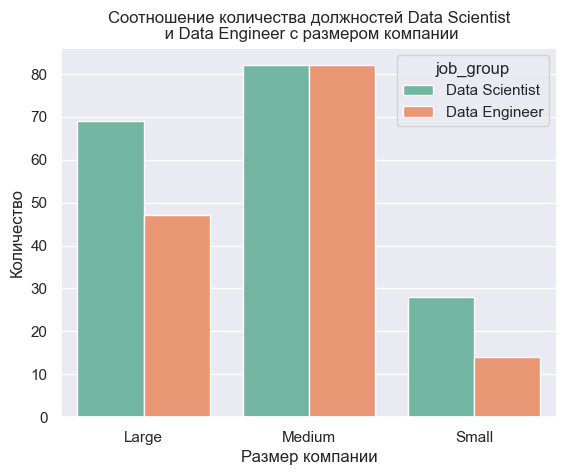

In [141]:
filtered_data = data[(data['job_group'] != 'other')].copy()
ax = sns.countplot(data=filtered_data, x=filtered_data['company_size'], hue='job_group')
ax.set(xlabel='Размер компании', ylabel='Количество')
plt.title('Соотношение количества должностей Data Scientist\n и Data Engineer с размером компании')
plt.show()

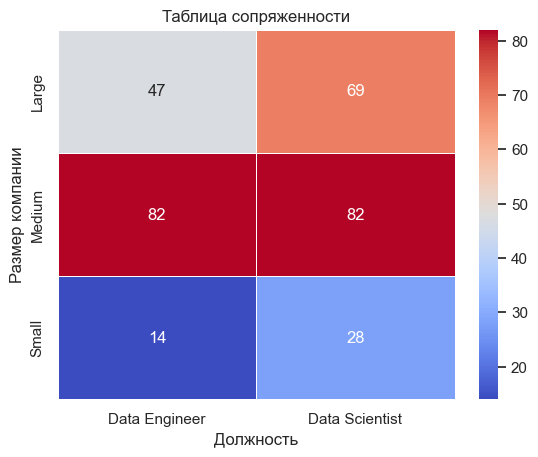

In [145]:
cross_tab = pd.crosstab(index=filtered_data['company_size'], columns=data['job_group'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Должность', ylabel='Размер компании')
plt.title('Таблица сопряженности')
plt.show()